In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [8]:
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

y_bar_list = [1.7, 1.8, 1.9, 2.0]
# y_bar_list = [1.7]
model_list = []

for y_bar in y_bar_list:
    _, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting, y_bar=y_bar, ϵ=2.)
    model_list.append(model)

Converged. Total iteration 5000: LHS Error: 6.275214336159962e-06; RHS Error 0.00012147491926300935
Converged. Total iteration 759: LHS Error: 9.929453481660744e-09; RHS Error 0.00046676607919667046
Converged. Total iteration 817: LHS Error: 9.843045489787983e-09; RHS Error 0.0022542761489702853
Converged. Total iteration 5000: LHS Error: 3.7803133786762366e-05; RHS Error 0.0008088471636117991
Converged. Total iteration 5000: LHS Error: 6.275214336159962e-06; RHS Error 0.00012147491926300935
Converged. Total iteration 759: LHS Error: 9.841605530525044e-09; RHS Error 0.0004676489251200927
Converged. Total iteration 816: LHS Error: 9.914973730928978e-09; RHS Error 0.002260398733028408
Converged. Total iteration 202: LHS Error: 9.259262245819855e-09; RHS Error 0.0007998586644601229
Converged. Total iteration 5000: LHS Error: 6.275214336159962e-06; RHS Error 0.00012147491926300935
Converged. Total iteration 758: LHS Error: 9.937745626409367e-09; RHS Error 0.00044872005520537467
Converged. 

In [14]:
# Simulation
et_list = []
yt_list = []
for model in model_list:
    et, yt, _, _ = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                             θ=np.mean(model['θ']), y_start=1., T=90)
    et_list.append(et)
    yt_list.append(yt)

In [15]:
@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

T = 90
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

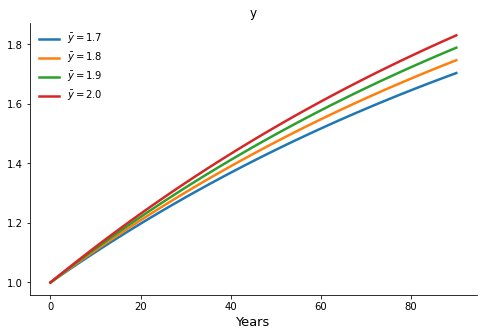

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(yt_list[0], label=r'$\bar{y}=1.7$', linewidth=2.5)
plt.plot(yt_list[1], label=r'$\bar{y}=1.8$', linewidth=2.5)
plt.plot(yt_list[2], label=r'$\bar{y}=1.9$', linewidth=2.5)
plt.plot(yt_list[3], label=r'$\bar{y}=2.0$', linewidth=2.5)

plt.xlabel('Years', fontsize=13)
plt.title('y')
plt.legend(frameon=False)

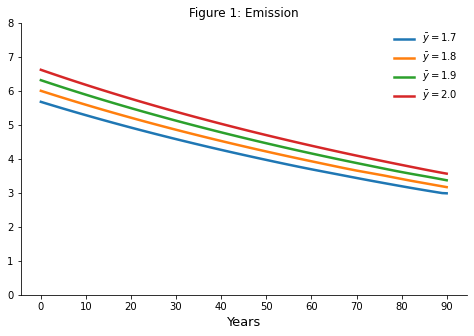

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(et_list[0], label=r'$\bar{y}=1.7$', linewidth=2.5)
plt.plot(et_list[1], label=r'$\bar{y}=1.8$', linewidth=2.5)
plt.plot(et_list[2], label=r'$\bar{y}=1.9$', linewidth=2.5)
plt.plot(et_list[3], label=r'$\bar{y}=2.0$', linewidth=2.5)

plt.xlabel('Years', fontsize=13)
plt.title('Figure 1: Emission')
plt.legend(frameon=False)
plt.xticks(np.arange(0, 100, 10))

plt.ylim(0, 8)

plt.savefig('../plots/emission.pdf')

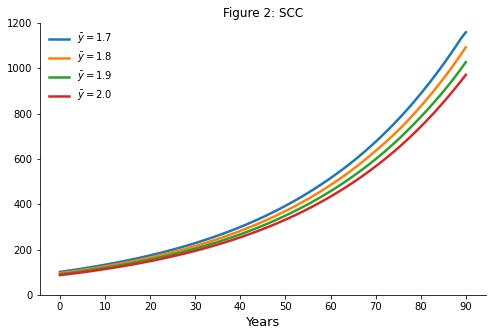

In [26]:
SCCt_list = [η*(0.025)*Kt/((1.-η)*et) * 1000 for et in et_list]

plt.figure(figsize=(8, 5))
plt.plot(SCCt_list[0], label=r'$\bar{y}=1.7$', linewidth=2.5)
plt.plot(SCCt_list[1], label=r'$\bar{y}=1.8$', linewidth=2.5)
plt.plot(SCCt_list[2], label=r'$\bar{y}=1.9$', linewidth=2.5)
plt.plot(SCCt_list[3], label=r'$\bar{y}=2.0$', linewidth=2.5)

plt.xlabel('Years', fontsize=13)
plt.title('Figure 2: SCC')
plt.legend(frameon=False)
plt.xticks(np.arange(0, 100, 10))

plt.ylim(0, 1200)
plt.savefig('../plots/scc.pdf')